In [1]:
import sys
# If you want to re-run, just modify this to where you put the NS_NFMC fork of the PyMC3 repo.
sys.path.insert(1, '/home/richard/pymc3_dev/')
import arviz as az
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
from pymc3.theanof import inputvars
import theano
import theano.tensor as tt
import seaborn as sns
import pandas as pd

print(f"Running on PyMC3 v{pm.__version__}")

az.style.use("arviz-darkgrid")

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Running on PyMC3 v3.11.0


In [2]:
n = 4

mu1 = np.ones(n) * (1.0 / 2)
mu2 = -mu1

stdev = 0.1
sigma = np.power(stdev, 2) * np.eye(n)
isigma = np.linalg.inv(sigma)
dsigma = np.linalg.det(sigma)

w1 = 0.3  # one mode with 0.3 of the mass 
w2 = 1 - w1  # the other mode with 0.7 of the mass

def two_gaussians(x):
    log_like1 = (
        -0.5 * n * tt.log(2 * np.pi)
        - 0.5 * tt.log(dsigma)
        - 0.5 * (x - mu1).T.dot(isigma).dot(x - mu1)
    )
    log_like2 = (
        -0.5 * n * tt.log(2 * np.pi)
        - 0.5 * tt.log(dsigma)
        - 0.5 * (x - mu2).T.dot(isigma).dot(x - mu2)
    )
    return pm.math.logsumexp([tt.log(w1) + log_like1, tt.log(w2) + log_like2])

with pm.Model() as model:
    X = pm.Uniform(
        "X",
        shape=n,
        lower=-2.0 * np.ones_like(mu1),
        upper=2.0 * np.ones_like(mu1),
        testval=-1.0 * np.ones_like(mu1),
    )
    #X = pm.Normal('X', mu=0, sigma=1, shape=n)
    
    llk = pm.Potential("llk", two_gaussians(X))
    
    smc_trace = pm.sample_smc(1000)
    init_samples = smc_trace.get_values('X')
    print(np.shape(init_samples))
    
with model:
    
    trace = pm.sample_nfmc(2000, init_samples=init_samples, optim_iter=1000, nf_iter=10, chains=1,
                           frac_validate=0.2, alpha=(0.75,0.75), parallel=False,
                           ftol=1.0e-12, NBfirstlayer=True, bw_factor=0.5, k_trunc=0.25, pareto=False)
    az_trace = az.from_pymc3(trace)

Initializing SMC sampler...
Sampling 2 chains in 0 job
/home/richard/pymc3_dev/pymc3/sampling.py:1924: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  warnings.warn(
Stage:   0 Beta: 0.010
Stage:   1 Beta: 0.029
Stage:   2 Beta: 0.066
Stage:   3 Beta: 0.139
Stage:   4 Beta: 0.290
Stage:   5 Beta: 0.617
Stage:   6 Beta: 1.000
/home/richard/pymc3_dev/pymc3/sampling.py:1924: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  warnings.warn(
Stage:   0 Beta: 0.011
Stage:   1 Beta: 0.030
Stage:   2 Beta: 0.067
Stage:   3 Beta: 0.142
Stage:   4 Beta: 0.293
Stage:   5 Beta: 0.616
Stage:   6 Beta: 1.000
Initializing normalizing flow based sampling...
Sampling 1 chain Cores available for optimization: 0


(2000, 4)
Fitting the first NF approx to the initial samples ...


Stage:   1, Normalizing Constant Estimate: 0.003968612707923937
Stage:   2, Normalizing Constant Estimate: 0.004019274476224078
Stage:   3, Normalizing Constant Estimate: 0.003938455880760855
Stage:   4, Normalizing Constant Estimate: 0.003868935503805931
Stage:   5, Normalizing Constant Estimate: 0.004115267991533691
Stage:   6, Normalizing Constant Estimate: 0.004018416351366408
Stage:   7, Normalizing Constant Estimate: 0.003869359510034128
Stage:   8, Normalizing Constant Estimate: 0.0037518101712634344
Stage:   9, Normalizing Constant Estimate: 0.0038617046891473894
Stage:  10, Normalizing Constant Estimate: 0.004033579600621485


In [3]:
nf_evidence = trace.report.evidence
print(f'NFMC calculated evidence = {nf_evidence[0]}')
weighted_samples = trace.report.weighted_samples[0]
q0_samples = weighted_samples[:2000, ...]
importance_weights = trace.report.importance_weights
q0_weights = importance_weights[0][:2000]
az_summary = az.summary(az_trace)
print(az_summary)

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


NFMC calculated evidence = 0.0039829579108605325
       mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
X[0] -0.208  0.463  -0.686    0.603       0.01    0.007    2096.0  2051.0   
X[1] -0.209  0.462  -0.679    0.609       0.01    0.007    2087.0  1921.0   
X[2] -0.201  0.465  -0.671    0.619       0.01    0.008    2093.0  1903.0   
X[3] -0.210  0.463  -0.658    0.629       0.01    0.007    2124.0  2124.0   

      ess_bulk  ess_tail  r_hat  
X[0]    2024.0    2041.0    NaN  
X[1]    2062.0    1848.0    NaN  
X[2]    2016.0    1776.0    NaN  
X[3]    2124.0    1920.0    NaN  


<Figure size 720x480 with 0 Axes>

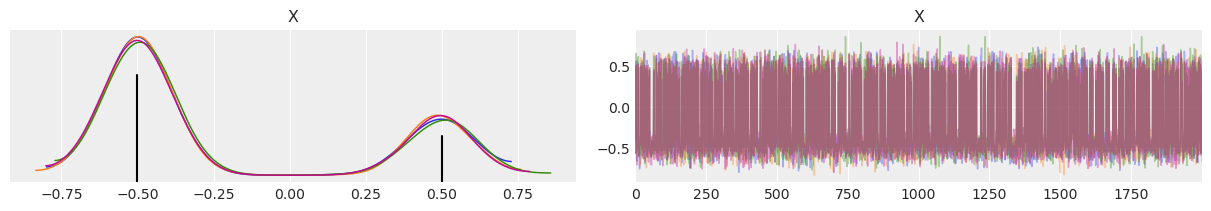

In [4]:
plt.figure()
ax = az.plot_trace(az_trace, compact=True)
for i in range(len(ax)):
    ax[i, 0].axvline(-0.5, 0, 0.7, color='k')
    ax[i, 0].axvline(0.5, 0, 0.3, color='k')
plt.show()

<Figure size 720x480 with 0 Axes>

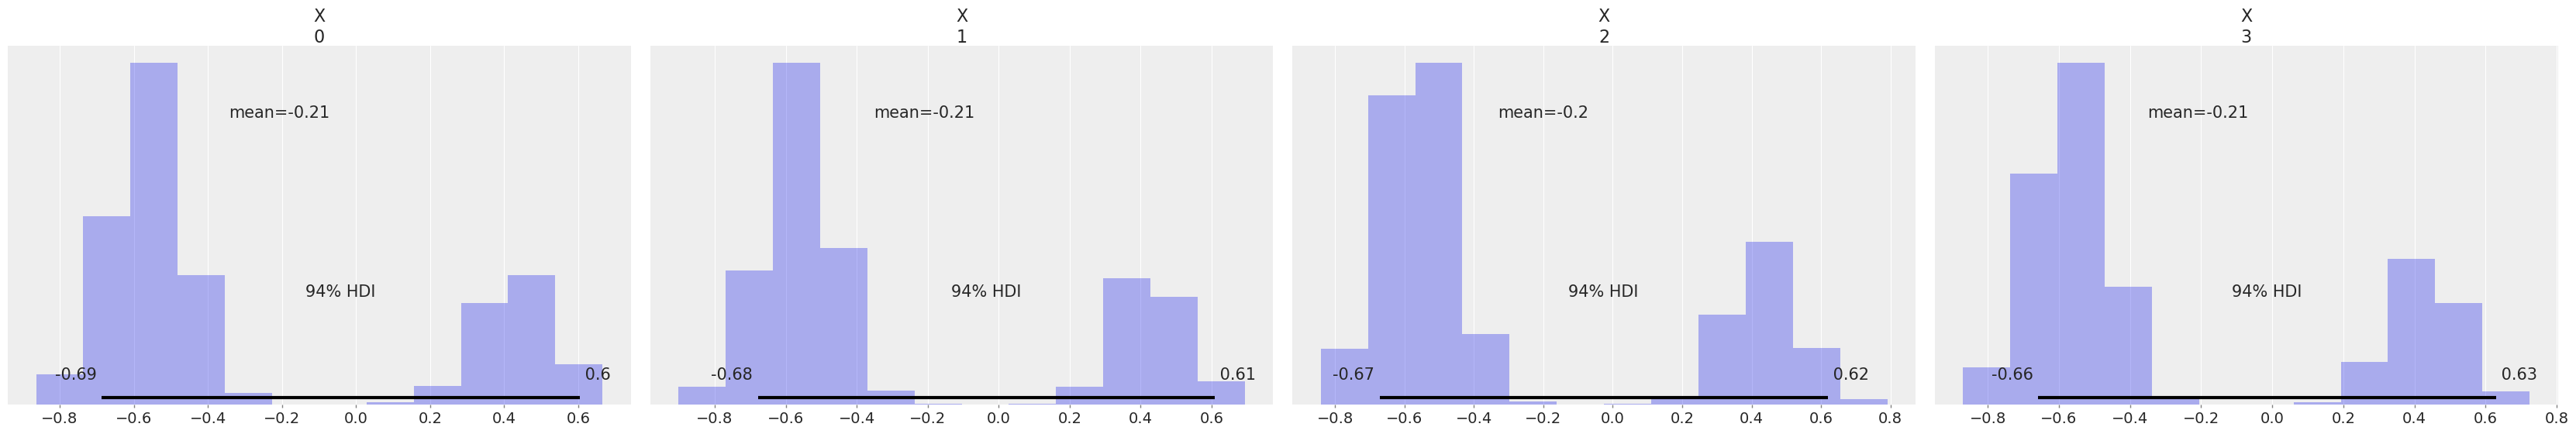

In [5]:
plt.figure()
az.plot_posterior(az_trace, kind='hist')
plt.show()

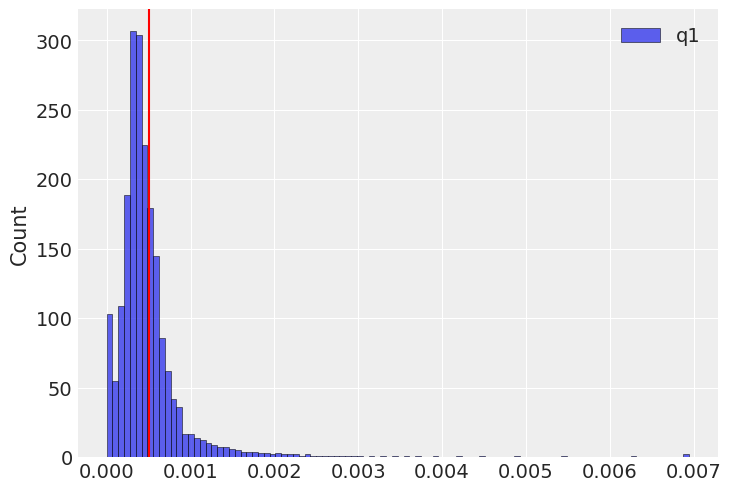

22000


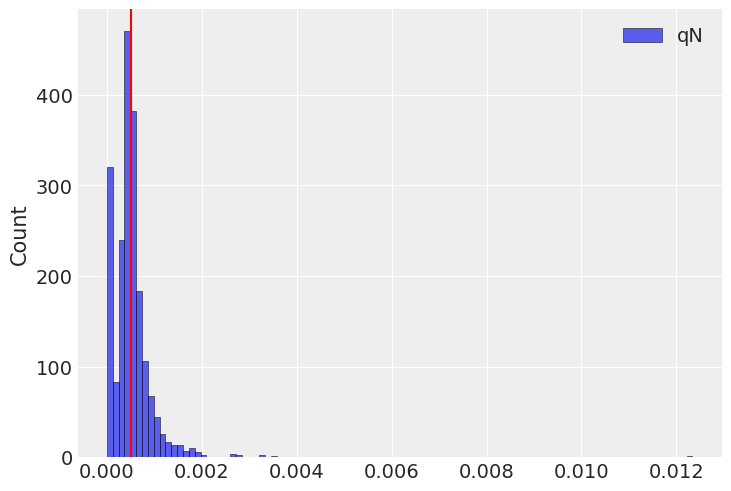

In [6]:
plt.figure()
sns.histplot(importance_weights[0][:2000], bins=100, label='q1')
plt.axvline(x=1/2000, color='r')
plt.legend(loc='upper right')
plt.show()

print(len(importance_weights[0]))

plt.figure()
sns.histplot(importance_weights[0][int(len(importance_weights[0]) - 2000):], bins=100, label='qN')
plt.axvline(x=1/2000, color='r')
plt.legend(loc='upper right')
plt.show()


Let's just check these results against those from SMC. 

In [7]:
with model:
    az_smc_trace = az.from_pymc3(smc_trace)

In [8]:
smc_evidence = np.exp(smc_trace.report.log_marginal_likelihood)
print(f'SMC calculated evidence: {smc_evidence}')
az_smc_summary = az.summary(az_smc_trace)
print(az_smc_summary)

SMC calculated evidence: [0.00347733 0.00512521]
       mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
X[0] -0.197  0.465  -0.670    0.608      0.011    0.008    1890.0  1890.0   
X[1] -0.201  0.468  -0.666    0.617      0.011    0.008    1899.0  1852.0   
X[2] -0.200  0.466  -0.672    0.615      0.011    0.008    1915.0  1627.0   
X[3] -0.200  0.468  -0.675    0.615      0.011    0.008    1903.0  1894.0   

      ess_bulk  ess_tail  r_hat  
X[0]    1907.0    1850.0    1.0  
X[1]    1963.0    1888.0    1.0  
X[2]    1952.0    1601.0    1.0  
X[3]    1987.0    1886.0    1.0  


<Figure size 720x480 with 0 Axes>

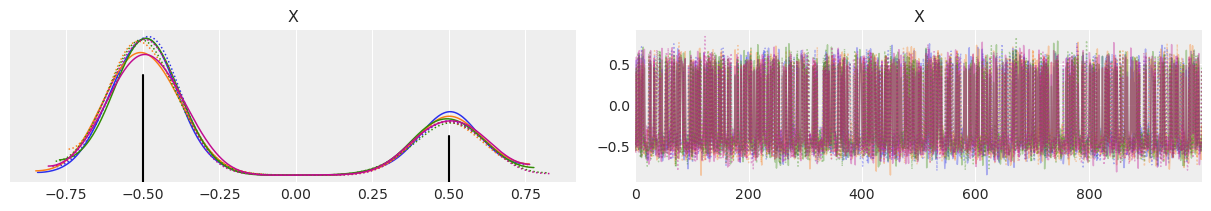

In [9]:
plt.figure()
ax = az.plot_trace(az_smc_trace, compact=True)
for i in range(len(ax)):
    ax[i, 0].axvline(-0.5, 0, 0.7, color='k')
    ax[i, 0].axvline(0.5, 0, 0.3, color='k')
plt.show()

<Figure size 720x480 with 0 Axes>

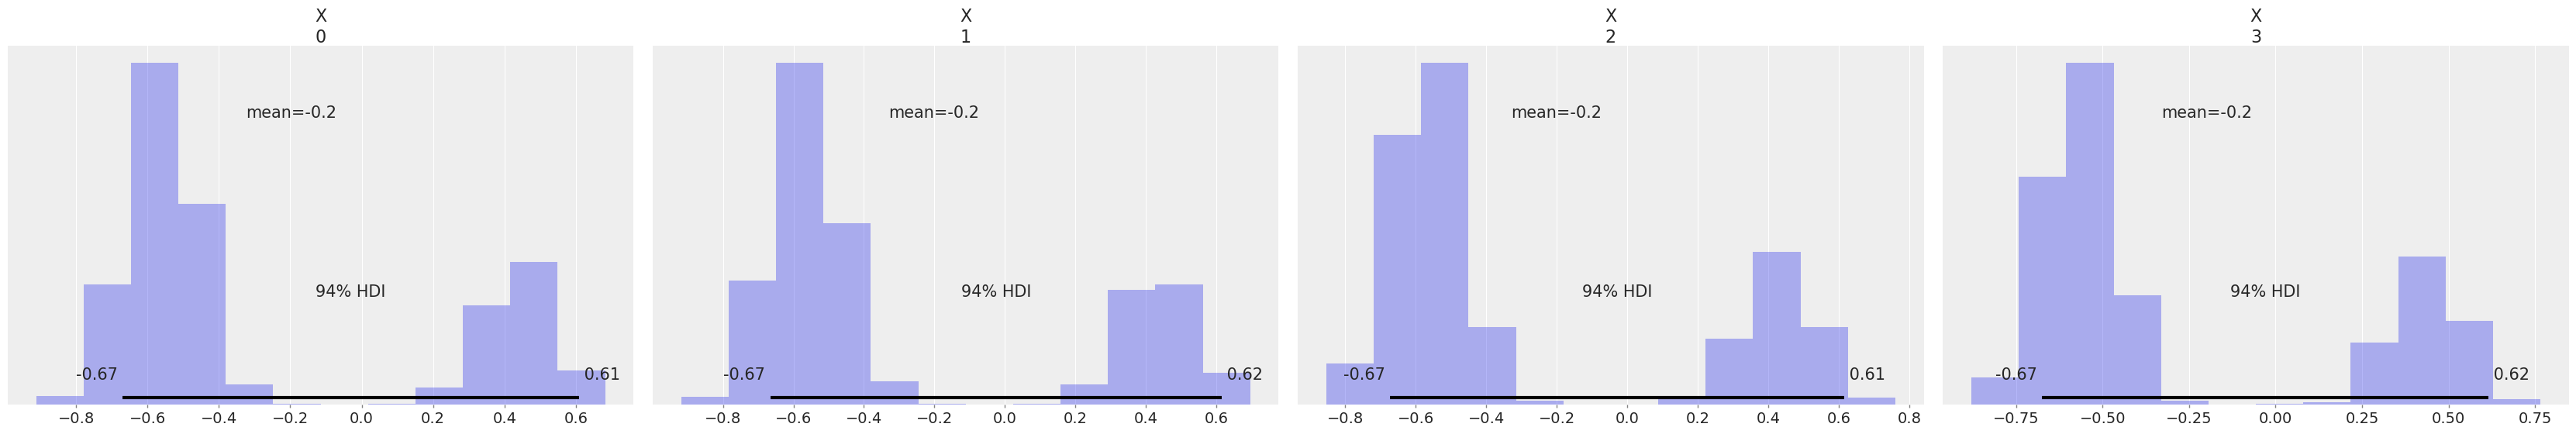

In [10]:
plt.figure()
az.plot_posterior(az_smc_trace, kind='hist')
plt.show()

Below I plot the X[0] posterior obtained from the NFMC and SMC runs. 

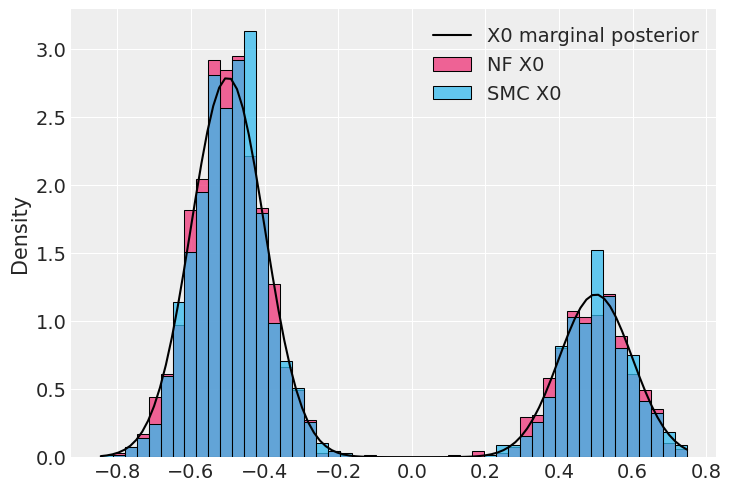

In [11]:
def marginal_two_gauss(x, mu1=0.5, mu2=-0.5, sigma=0.1):
    like1 = np.exp(-(x - mu1)**2 / (2 * sigma**2)) / np.sqrt(2 * np.pi * sigma**2)
    like2 = np.exp(-(x - mu2)**2 / (2 * sigma**2)) / np.sqrt(2 * np.pi * sigma**2)
    return w1 * like1 + w2 * like2

nf_df = az_trace.to_dataframe()
smc_df = az_smc_trace.to_dataframe()

nf_x0 = nf_df[('X[0]', 0)].to_numpy()
nf_x1 = nf_df[('X[1]', 1)].to_numpy()
nf_x2 = nf_df[('X[2]', 2)].to_numpy()
nf_x3 = nf_df[('X[3]', 3)].to_numpy()
smc_x0 = smc_df[('X[0]', 0)].to_numpy()
smc_x1 = smc_df[('X[1]', 1)].to_numpy()
smc_x2 = smc_df[('X[2]', 2)].to_numpy()
smc_x3 = smc_df[('X[3]', 3)].to_numpy()

x_vals = np.linspace(min(np.amin(nf_x0), np.amin(smc_x0)), max(np.amax(nf_x0), np.amax(smc_x0)), 100)
y_vals = marginal_two_gauss(x_vals)

bins = np.linspace(min(np.amin(nf_x0), np.amin(smc_x0)), max(np.amax(nf_x0), np.amax(smc_x0)), 50)
plt.figure()
sns.histplot(nf_x0, label='NF X0', bins=bins, stat='density', color='#EE3377')
sns.histplot(smc_x0, label='SMC X0', bins=bins, stat='density', color='#33BBEE')
plt.plot(x_vals, y_vals, color='k', label='X0 marginal posterior')
plt.legend(loc='upper right')
plt.show()

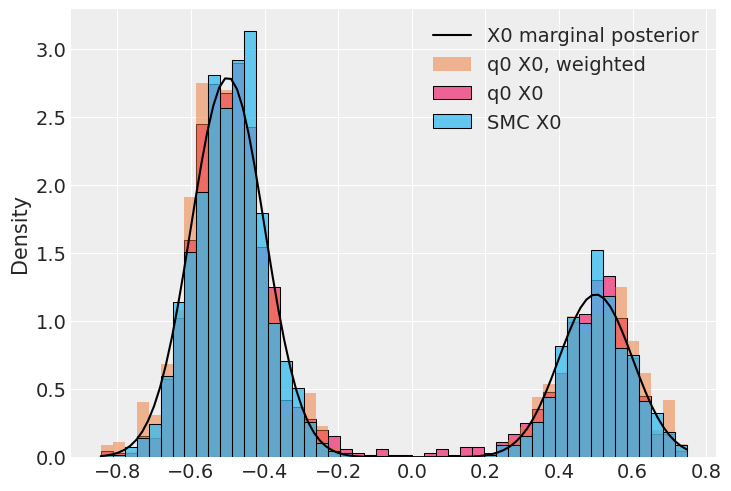

In [12]:
plt.figure()
sns.histplot(q0_samples[:,0], label='q0 X0', bins=bins, stat='density', color='#EE3377')
plt.hist(q0_samples[:,0], weights=q0_weights/np.sum(q0_weights), label='q0 X0, weighted', 
             bins=bins, density=True, color='#EE7733', alpha=0.5)
sns.histplot(smc_x0, label='SMC X0', bins=bins, stat='density', color='#33BBEE')
plt.plot(x_vals, y_vals, color='k', label='X0 marginal posterior')
plt.legend(loc='upper right')
plt.show()

In [13]:
rg_model = pm.Model()
x = np.arange(10)
y = 2 * x + 1 + np.random.normal(scale=0.1)

with rg_model:

    a = pm.Normal('a', mu=2, sigma=1)
    b = pm.Normal('b', mu=1, sigma=1)

    like = pm.Normal('like', mu=a*x+b, sigma=0.1, observed=y)
    
    nuts_trace = pm.sample(1000)
    
    a_samples = nuts_trace.get_values('a')
    b_samples = nuts_trace.get_values('b')

init_samples = np.column_stack((b_samples, a_samples))
print(init_samples)
print(np.shape(init_samples))


with rg_model:
    
    rg_trace = pm.sample_nfmc(2000, init_samples=init_samples, optim_iter=1000, nf_iter=10, chains=1,
                              frac_validate=0.2, alpha=(0.75,0.75), parallel=False, bw_factor=0.5,
                              k_trunc=0.25, pareto=False)
    rg_az_trace = az.from_pymc3(rg_trace)

/home/richard/pymc3_dev/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [b, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.
The number of effective samples is smaller than 25% for some parameters.
Initializing normalizing flow based sampling...
Sampling 1 chain Cores available for optimization: 0


[[0.8769163  1.99772051]
 [0.82644252 1.99983054]
 [0.80028644 2.00077621]
 ...
 [0.86729647 1.98854523]
 [0.86729647 1.98854523]
 [0.94048453 1.99706826]]
(2000, 2)
Fitting the first NF approx to the initial samples ...


Stage:   1, Normalizing Constant Estimate: 349.14539282976125


Normalizing constant estimate has stabilised - ending NF fits.


<Figure size 720x480 with 0 Axes>

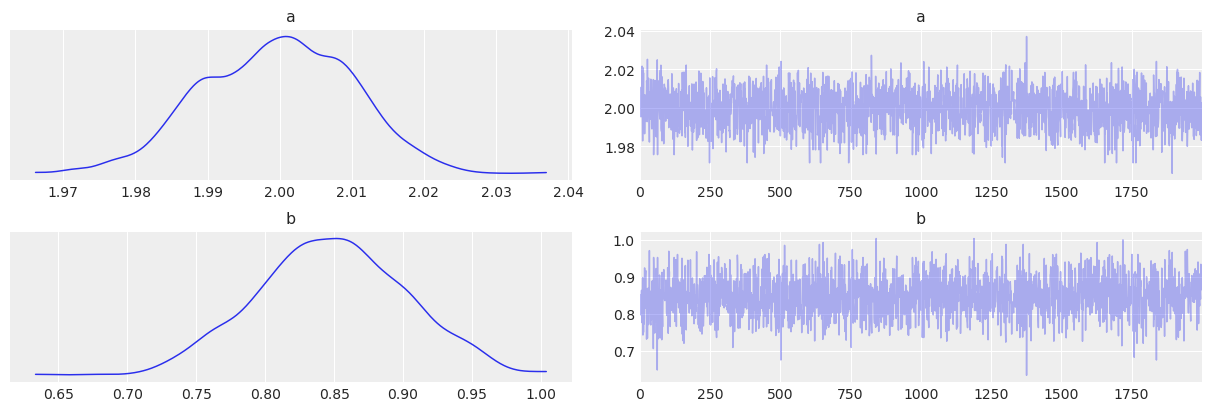

In [14]:
plt.figure()
ax = az.plot_trace(rg_az_trace)
plt.show()

Let's look at what happens if we initialize with samples from a Gaussian distribution that is too narrow.

In [15]:
rg_df = az.summary(rg_az_trace)
init_samples = np.random.multivariate_normal(mean=np.array([rg_df['mean']['b'], rg_df['mean']['a']]), 
                                             cov=np.diagflat(np.array([rg_df['sd']['b']**2, rg_df['sd']['a']**2]))/4, 
                                             size=2000)
with rg_model:
    
    rg_narrow_trace = pm.sample_nfmc(2000, init_samples=init_samples, optim_iter=1000, nf_iter=10, chains=1,
                              frac_validate=0.2, alpha=(0.75,0.75), parallel=False, bw_factor=0.5,
                              k_trunc=0.25, pareto=False, norm_tol=1e-2)
    rg_narrow_az_trace = az.from_pymc3(rg_narrow_trace)

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
Initializing normalizing flow based sampling...
Sampling 1 chain Cores available for optimization: 0


Fitting the first NF approx to the initial samples ...


Stage:   1, Normalizing Constant Estimate: 276.68135352547
Stage:   2, Normalizing Constant Estimate: 356.9784564321339
Stage:   3, Normalizing Constant Estimate: 352.1479267088072
Stage:   4, Normalizing Constant Estimate: 337.13811212714836
Stage:   5, Normalizing Constant Estimate: 352.7566819144834


Normalizing constant estimate has stabilised - ending NF fits.


<Figure size 720x480 with 0 Axes>

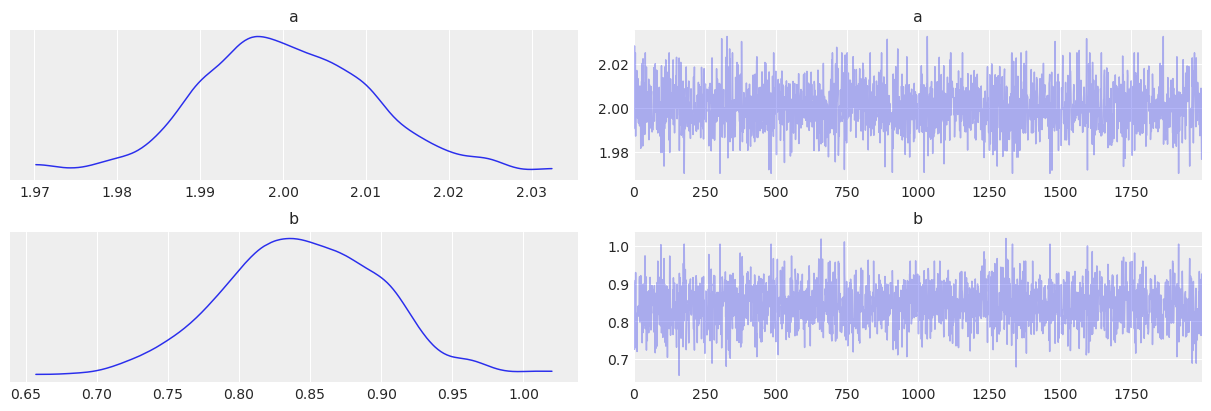

In [16]:
plt.figure()
ax = az.plot_trace(rg_narrow_az_trace)
plt.show()

In [17]:
rg_df = az.summary(rg_az_trace)
init_samples = np.random.multivariate_normal(mean=np.array([rg_df['mean']['b'], rg_df['mean']['a']]), 
                                             cov=np.diagflat(np.array([rg_df['sd']['b']**2, rg_df['sd']['a']**2]))/4, 
                                             size=2000)
with rg_model:
    
    rg_narrow_trace = pm.sample_nfmc(2000, init_samples=init_samples, optim_iter=1000, nf_iter=10, chains=1,
                              frac_validate=0.2, alpha=(0.9,0.9), parallel=False, bw_factor=0.5,
                              k_trunc=0.25, pareto=False, norm_tol=1e-2)
    rg_narrow_az_trace = az.from_pymc3(rg_narrow_trace)

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
Initializing normalizing flow based sampling...
Sampling 1 chain Cores available for optimization: 0


Fitting the first NF approx to the initial samples ...


Stage:   1, Normalizing Constant Estimate: 275.7350005795149
Stage:   2, Normalizing Constant Estimate: 311.55835020544464
Stage:   3, Normalizing Constant Estimate: 331.78546400780004
Stage:   4, Normalizing Constant Estimate: 372.8051967476202
Stage:   5, Normalizing Constant Estimate: 351.47200852014123
Stage:   6, Normalizing Constant Estimate: 356.6991573494204
Stage:   7, Normalizing Constant Estimate: 350.8495749861814


Normalizing constant estimate has stabilised - ending NF fits.


<Figure size 720x480 with 0 Axes>

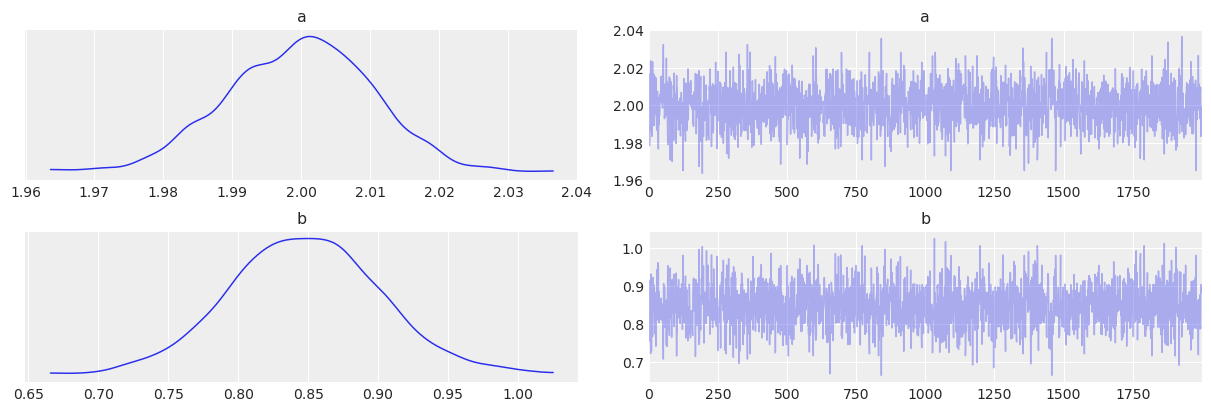

In [19]:
plt.figure()
ax = az.plot_trace(rg_narrow_az_trace)
plt.show()

In [20]:
rg_df = az.summary(rg_az_trace)
init_samples = np.random.multivariate_normal(mean=np.array([rg_df['mean']['b'], rg_df['mean']['a']]), 
                                             cov=np.diagflat(np.array([rg_df['sd']['b']**2, rg_df['sd']['a']**2]))/4, 
                                             size=2000)
with rg_model:
    
    rg_narrow_trace = pm.sample_nfmc(2000, init_samples=init_samples, optim_iter=1000, nf_iter=10, chains=1,
                              frac_validate=0.2, alpha=None, parallel=False, bw_factor=0.5,
                              k_trunc=0.25, pareto=False, norm_tol=1e-2)
    rg_narrow_az_trace = az.from_pymc3(rg_narrow_trace)

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
Initializing normalizing flow based sampling...
Sampling 1 chain Cores available for optimization: 0


Fitting the first NF approx to the initial samples ...


Stage:   1, Normalizing Constant Estimate: 253.38206256034275
Stage:   2, Normalizing Constant Estimate: 346.9854430935027
Stage:   3, Normalizing Constant Estimate: 335.59115261200725
Stage:   4, Normalizing Constant Estimate: 342.7714302577863
Stage:   5, Normalizing Constant Estimate: 350.1510114200305


Normalizing constant estimate has stabilised - ending NF fits.


<Figure size 720x480 with 0 Axes>

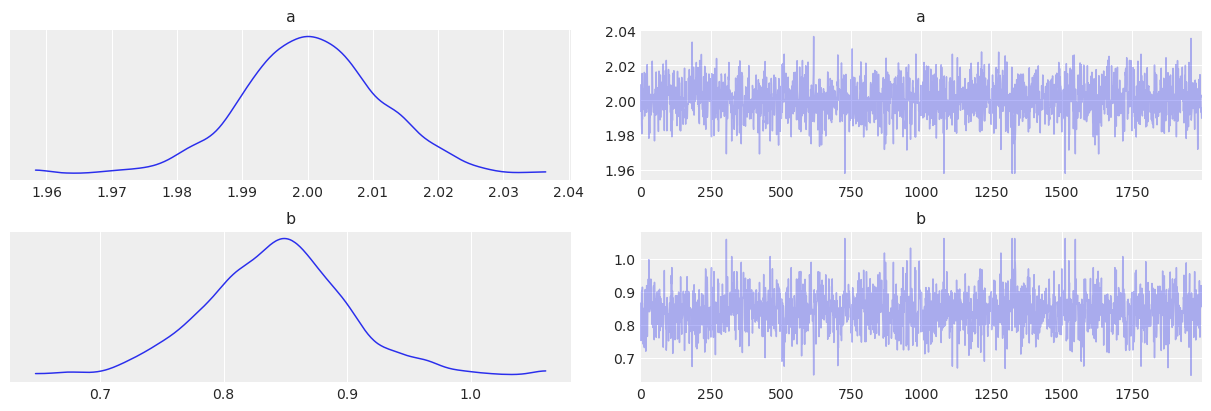

In [21]:
plt.figure()
ax = az.plot_trace(rg_narrow_az_trace)
plt.show()

In [23]:
rg_df = az.summary(rg_az_trace)
init_samples = np.random.multivariate_normal(mean=np.array([rg_df['mean']['b'], rg_df['mean']['a']]), 
                                             cov=np.diagflat(np.array([rg_df['sd']['b']**2, rg_df['sd']['a']**2]))/4, 
                                             size=2000)
with rg_model:
    
    rg_narrow_trace = pm.sample_nfmc(2000, init_samples=init_samples, optim_iter=1000, nf_iter=20, chains=1,
                              frac_validate=0.2, alpha=None, parallel=False, bw_factor=0.5,
                              k_trunc=0.25, pareto=False, norm_tol=1e-3)
    rg_narrow_az_trace = az.from_pymc3(rg_narrow_trace)

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
Initializing normalizing flow based sampling...
Sampling 1 chain Cores available for optimization: 0


Fitting the first NF approx to the initial samples ...


Stage:   1, Normalizing Constant Estimate: 212.46205023409388
Stage:   2, Normalizing Constant Estimate: 349.80423893560675
Stage:   3, Normalizing Constant Estimate: 287.01019928507685
Stage:   4, Normalizing Constant Estimate: 340.90547462499967
Stage:   5, Normalizing Constant Estimate: 358.10564692970223
Stage:   6, Normalizing Constant Estimate: 359.5749805369431
Stage:   7, Normalizing Constant Estimate: 346.0470843716024
Stage:   8, Normalizing Constant Estimate: 348.24150677029183
Stage:   9, Normalizing Constant Estimate: 351.83733776058597
Stage:  10, Normalizing Constant Estimate: 354.4637527885397
Stage:  11, Normalizing Constant Estimate: 348.08432721226797
Stage:  12, Normalizing Constant Estimate: 350.02748878720644
Stage:  13, Normalizing Constant Estimate: 351.1416602862509
Stage:  14, Normalizing Constant Estimate: 349.1104855221302


Normalizing constant estimate has stabilised - ending NF fits.


<Figure size 720x480 with 0 Axes>

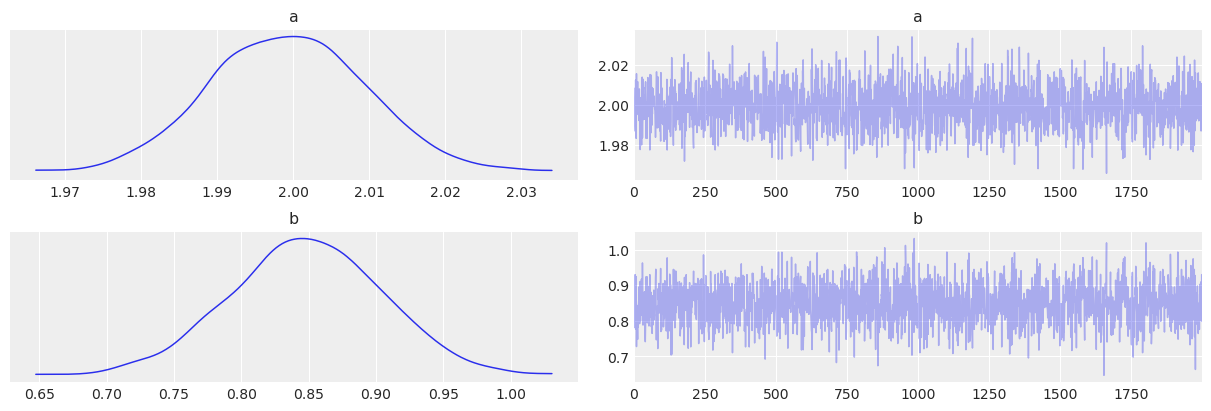

In [24]:
plt.figure()
ax = az.plot_trace(rg_narrow_az_trace)
plt.show()

Test initializing with full-rank EL2O

In [27]:
with rg_model:
    
    el2o_trace = pm.sample_nfmc(2000, init_el2o='full_rank', optim_iter=1000, nf_iter=20, chains=1,
                              frac_validate=0.2, alpha=(0.75, 0.75), parallel=False, bw_factor=0.5,
                              k_trunc=0.25, pareto=False, norm_tol=1e-2)
    el2o_az_trace = az.from_pymc3(el2o_trace)

Initializing normalizing flow based sampling...
INFO:pymc3:Initializing normalizing flow based sampling...
Sampling 1 chain Cores available for optimization: 0
INFO:pymc3:Sampling 1 chain Cores available for optimization: 0


Initializing with EL2O approximation family: full_rank



MAP estimate = {'a': array(1.99991639), 'b': array(0.84668911)}
Final EL2O mu = [[0.84668911 1.99991639]]
Final EL2O Sigma = [[ 0.00344236 -0.00054351]
 [-0.00054351  0.0001209 ]]
Fitting the first NF approx to the initial samples ...


Stage:   1, Normalizing Constant Estimate: 360.6068710378644
INFO:pymc3:Stage:   1, Normalizing Constant Estimate: 360.6068710378644
Stage:   2, Normalizing Constant Estimate: 351.4839800952096
INFO:pymc3:Stage:   2, Normalizing Constant Estimate: 351.4839800952096


Normalizing constant estimate has stabilised - ending NF fits.


<Figure size 720x480 with 0 Axes>

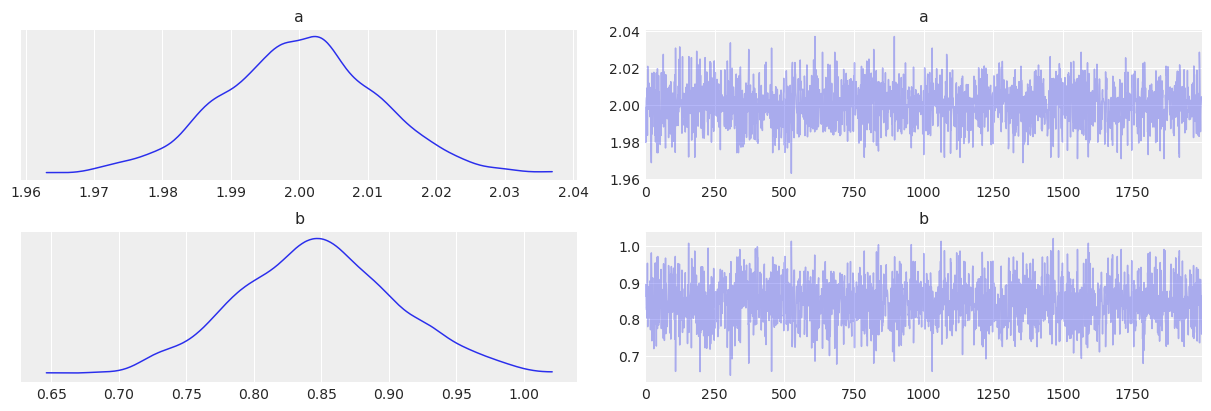

In [28]:
plt.figure()
ax = az.plot_trace(el2o_az_trace)
plt.show()

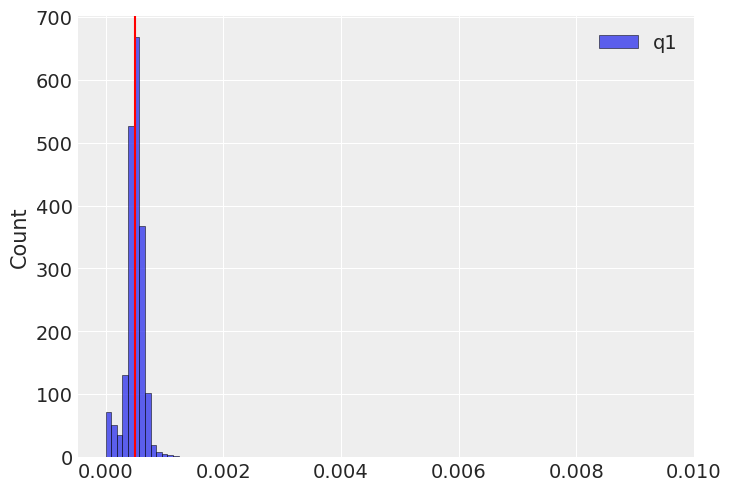

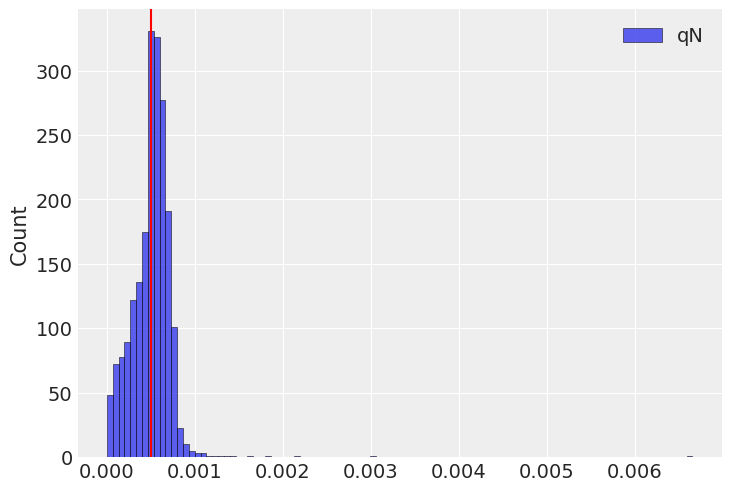

In [29]:
rg_importance_weights = rg_trace.report.importance_weights

plt.figure()
sns.histplot(rg_importance_weights[0][:2000], bins=100, label='q1')
plt.axvline(x=1/2000, color='r')
plt.legend(loc='upper right')
plt.show()


plt.figure()
sns.histplot(rg_importance_weights[0][int(len(rg_importance_weights[0]) - 2000):], bins=100, label='qN')
plt.axvline(x=1/2000, color='r')
plt.legend(loc='upper right')
plt.show()


In [30]:
with rg_model:
    nuts_az_trace = az.from_pymc3(nuts_trace)

<Figure size 720x480 with 0 Axes>

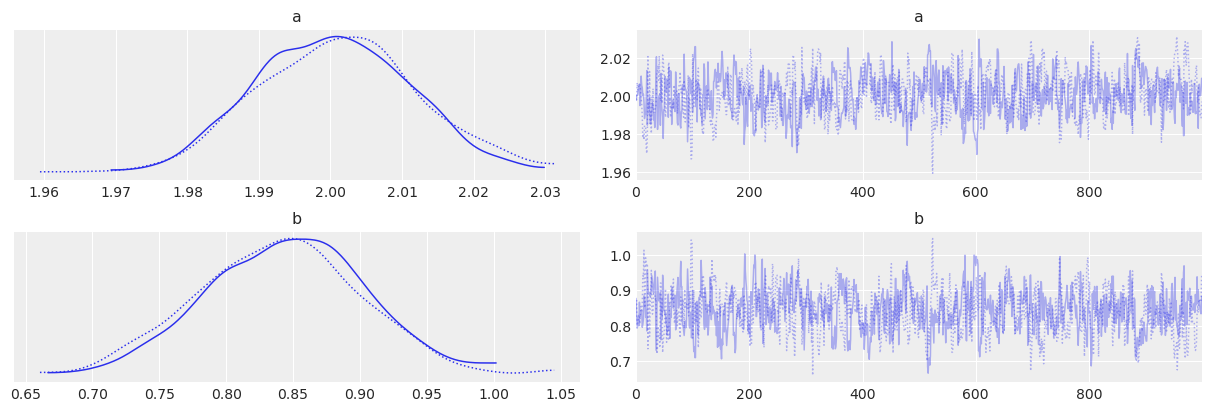

In [31]:
plt.figure()
ax = az.plot_trace(nuts_az_trace)
plt.show()

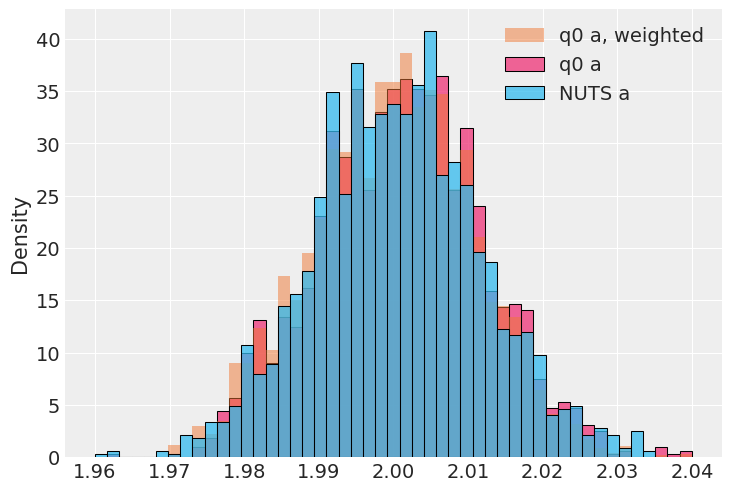

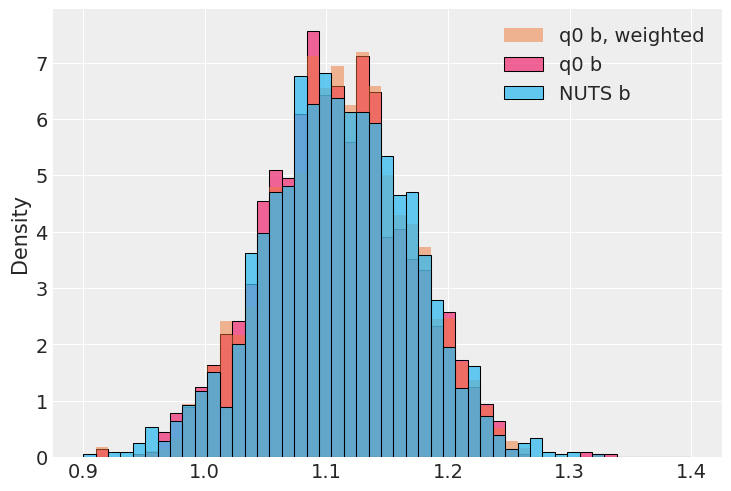

In [22]:
rg_weighted_samples = rg_trace.report.weighted_samples[0]
rg_q0_samples = rg_weighted_samples[:2000, ...]
rg_importance_weights = rg_trace.report.importance_weights
rg_q0_weights = rg_importance_weights[0][:2000]

bins = np.linspace(1.96, 2.04, 50)
plt.figure()
sns.histplot(rg_q0_samples[:,1], label='q0 a', bins=bins, stat='density', color='#EE3377')
plt.hist(rg_q0_samples[:,1], weights=rg_q0_weights/np.sum(rg_q0_weights), label='q0 a, weighted', 
             bins=bins, density=True, color='#EE7733', alpha=0.5)
sns.histplot(a_samples, label='NUTS a', bins=bins, stat='density', color='#33BBEE')
plt.legend(loc='upper right')
plt.show()

bins = np.linspace(0.9, 1.4, 50)
plt.figure()
sns.histplot(rg_q0_samples[:,0], label='q0 b', bins=bins, stat='density', color='#EE3377')
plt.hist(rg_q0_samples[:,0], weights=rg_q0_weights/np.sum(rg_q0_weights), label='q0 b, weighted', 
             bins=bins, density=True, color='#EE7733', alpha=0.5)
sns.histplot(b_samples, label='NUTS b', bins=bins, stat='density', color='#33BBEE')
plt.legend(loc='upper right')
plt.show()

In [52]:
def z_integrand(a, b):
    p_a = np.exp(-(a - 2)**2 / 2) / np.sqrt(2 * np.pi)
    p_b = np.exp(-(b - 1)**2 / 2) / np.sqrt(2 * np.pi)
    l = np.prod(np.exp(-(y - a * x - b)**2 / (2 * 0.1**2)) / np.sqrt(2 * np.pi * 0.1**2))
    return l * p_a * p_b

from scipy import integrate
result = integrate.dblquad(z_integrand, 0.8, 1.2, 1.96, 2.04)
print(result)

(354.47752481652395, 1.4508249154328995e-05)


Hierarchical Radon Model ....

In [36]:
data = pd.read_csv(pm.get_data("radon.csv"))
data["log_radon"] = data["log_radon"].astype(theano.config.floatX)
county_names = data.county.unique()
county_idx = data.county_code.values

n_counties = len(data.county.unique())

In [37]:
with pm.Model() as hierarchical_model:
    # Hyperpriors for group nodes
    mu_a = pm.Normal("mu_a", mu=0.0, sigma=100)
    sigma_a = pm.HalfNormal("sigma_a", 5.0)
    mu_b = pm.Normal("mu_b", mu=0.0, sigma=100)
    sigma_b = pm.HalfNormal("sigma_b", 5.0)

    # Intercept for each county, distributed around group mean mu_a
    # Above we just set mu and sd to a fixed value while here we
    # plug in a common group distribution for all a and b (which are
    # vectors of length n_counties).
    a = pm.Normal("a", mu=mu_a, sigma=sigma_a, shape=n_counties)
    # Intercept for each county, distributed around group mean mu_a
    b = pm.Normal("b", mu=mu_b, sigma=sigma_b, shape=n_counties)

    # Model error
    eps = pm.HalfCauchy("eps", 5.0)

    radon_est = a[county_idx] + b[county_idx] * data.floor.values

    # Data likelihood
    radon_like = pm.Normal("radon_like", mu=radon_est, sigma=eps, observed=data.log_radon)

First, let's sample the posterior using NUTS.

In [39]:
with hierarchical_model:
    hierarchical_trace = pm.sample(2000, tune=2000, target_accept=0.9)
    hierarchical_az_trace = az.from_pymc3(hierarchical_trace)

/home/richard/pymc3_dev/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [eps, b, a, sigma_b, mu_b, sigma_a, mu_a]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 115 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


<Figure size 720x480 with 0 Axes>

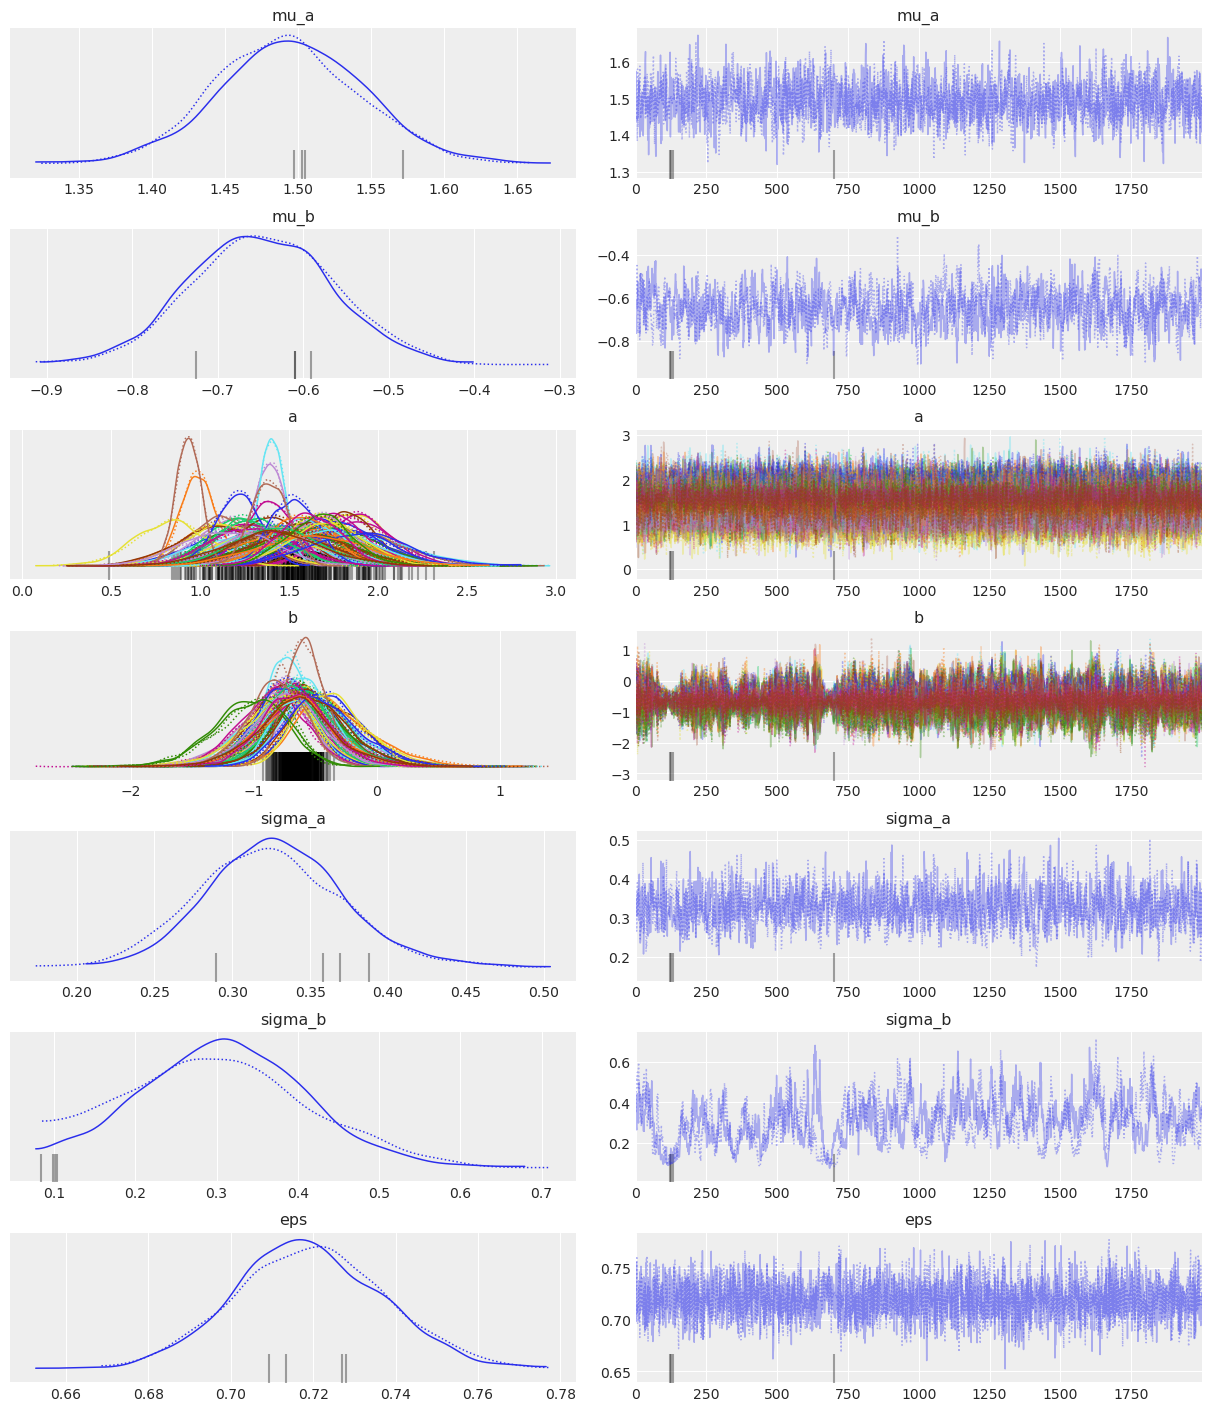

In [43]:
plt.figure()
ax = az.plot_trace(hierarchical_az_trace)
plt.show()

Now let's look at using NFMC.

In [44]:
with hierarchical_model:
    hierarchical_nf_trace = pm.sample_nfmc(500, optim_iter=1000, nf_iter=20, chains=1,
                                           frac_validate=0.2, alpha=(0.5,0.5), parallel=False)
    hierarchical_az_nf_trace = az.from_pymc3(hierarchical_nf_trace)

Initializing normalizing flow based sampling...
Sampling 1 chain Cores available for optimization: 0


Running initial optimization ...
Fitting the first NF approx to the prior optimized samples ...


KeyboardInterrupt: 